# Extracting Knowledge Graph 

We'll be using the 211 Human Services Taxonomy and the corresponding Taxonomy codes from the IN 211 data to construct an initial (heterogeneous) information network from the data.  
Afterwards, we'll look for relations and connections between services


## 211 + Taxonomy data integration

The original schema of the taxonomy is very annoying to parse and has a lot of info we're not interested.  
We'll refactor it into a form that's easier to work with and save
several helper data files.  

We'll end with:
- taxo_nodes.json: a list of node dicts with their properties
- taxo_edge_list.json: a list of 3-tuple edges: 
    (node1_num, <Relation\>, node2_num)
- node_num_to_code.json: translates a unique node_num to it's taxonomy code
- code_to_node_num.json: same as above, but the inverse
- name_to_node_num.json: a node name and it's corresponding node number
- taxo_refs.csv: a list of synonyms or alternate names for the different taxonomy entities/terms. **Similar to user search queries so could be used for recommendation training**
- taxo_facets.csv: a list of intended use of the taxonomy entities/terms.  
    *Allowable values are: Service, Target, Organization/Facility Type, Modality, and Named Program*. Could be used as Main Categories


In [0]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/code_and_data'
!echo "Project dir contents:" && ls "$prefix"
!echo -e "\nColab Notebook home dir:" && ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Project dir contents:
211_IN_Data_Parsing.ipynb    nd_care-net.tar.gz
BANE			     Node_Text_Embedding_Doc2Vec.ipynb
BANE_embeddings.ipynb	     Node_Text_Embedding_GPT-2-Copy1.ipynb
binder			     Node_Text_Embedding_sBERT.ipynb
CX_DB8			     README.md
data			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
figures			     TENE
Graph_Data_Extraction.ipynb  TENE_embeddings.ipynb
models			     USE_multi_lang_embed_serv_sim_search.ipynb

Colab Notebook home dir:
drive  sample_data


In [0]:
!pip3 install xmlschema networkx matplotlib pandas

In [0]:
import xml.etree.ElementTree as ET 
import xmlschema
from os import path
import networkx as nx
import matplotlib.pyplot as plt
from sys import exit
import json
import csv
import pandas as pd

In [0]:
def save_to_json(taxo_dict, dst):
    dst = path.join(prefix, dst)
    taxo_json = json.dumps(taxo_dict)
    with open(dst, 'w+') as taxonomy_json:
        taxonomy_json.write(taxo_json)

def save_to_csv(taxo_list, dst):
    dst = path.join(prefix, dst)
    with open(dst, 'w+') as csv_file:
        writer = csv.writer(csv_file)
        # write a single csv row
        if isinstance(taxo_list[0], list):
          csv_single_line = ','.join(taxo_list)
          print("Saving line to csv: {}".format(taxo_list))
          csv_file.write(csv_single_line)
          
        else:
          for line in taxo_list:
            writer.writerow(line)

In [0]:
taxonomy_path = path.join(prefix, 'data', 'currentTaxonomy_211.xml')
taxo_schema_path = path.join(prefix, 'data', '211_taxonomy_xml_schema.xsd')

# validate that taxonomy follows their own schema

if not path.isfile(taxo_schema_path):
    print("Fatal error! Taxonomy schema file {} does not exist".format(taxo_schema_path))
    exit(1)

elif not path.isfile(taxonomy_path):
    print("Fatal error! Taxonomy file {} does not exist".format(taxonomy_path))
    exit(1)
else:

    # describes taxonomy's structure, attributes, etc
    taxo_schema = xmlschema.XMLSchema(taxo_schema_path, converter=xmlschema.AbderaConverter)

    if taxo_schema.is_valid(taxonomy_path):
        
        # load the 211 Human Services taxonomy xml and as a json
        services_taxonomy = ET.parse(taxonomy_path)
        taxonomy_dict = taxo_schema.to_dict(taxonomy_path)
        taxo_root = services_taxonomy.getroot()
        
        # dict is very dense and wouldn't print without increasing print IO limit. 
        # save to file for analysis and choosing attrs to keep
        save_to_json(taxo_dict=taxonomy_dict, dst='data/temp_taxo.json')
            
    else: 
        print("Error! The taxonomy doesn't follow provided schema and is invalid. List of errors:")
        for i, err in enumerate(schema_errs):
            print("{}. {}".format(i, err))

In [0]:
# extract info to graph out taxonomy 

%matplotlib inline

node_num = 0

# helper json or csv files to be saved later
node_num_to_code = {}
code_to_node_num = {}
name_to_node_num = {}
kws_to_node_num = {}
kw_nodes = {}
taxo_nodes = {}
taxo_edgelist = set()
taxo_refs = set()
taxo_facets = set(['Named Programs', 'Target', 'Service', 'Modality/Delivery Format', 'Organization/Facility Type'])
#taxo_facet_rels = {'Named Programs': 'isA', 'Target', 'Service', 'Modality/Delivery Format', 'Organization/Facility Type'}

In [0]:
def parseNode(node_info, node_code):
    
    # added related key even if not present to work around 
    # key value type inconsistency
    global node_num
    node = {
        'node_num': node_num,
        'name': node_info['name'],
        'description': node_info['definition'],
        'facet': node_info['facet'],
        'code': node_code,
        'related': [],
        'type': 'C', # 211 Taxonomy Code node type
        'child_nodes': []
    }
    
    # for translating related concepts later
    code_to_node_num[node_code] = node_num
    node_num_to_code[node_num] = node_code
    # save as list since name is not a unique ID
    if node['name'] in name_to_node_num:
        name_to_node_num[node['name']] = name_to_node_num[node['name']] + [node_num]
    else:
        name_to_node_num[node['name']] = [node_num]
    
    
    # some nodes don't have these attributes
    if 'comments' in node_info:
        node['comments'] = node_info['comments']
        
    if 'useReference' in node_info:
        keywords = node_info['useReference']
#         node['keywords'] = keywords
        # add the elements from the keywords list to the set
        [(lambda el: taxo_refs.add(el))(el) for el in keywords]
        # add edges between nodes and query terms
#         for kw in keywords:
#             if kw not in kws_to_node_num:
#                 node_num += 1
#                 kws_to_node_num[kw] = node_num
#                 kw_node = {
#                     'descr': kw,
#                     'code': node_code,
#                     'node_num': node_num,
#                     'type': 'K' # keyword node type
#                 }
#                 kw_nodes[node_num] = kw_node
#                 taxo_edgelist.add((node_num, 'isRelated', node['node_num']))
        # avoid adding string instead of list
        if isinstance(keywords, str):
          keywords = [keywords]
        node['keywords'] = keywords
        
    if 'relatedConcept' in node_info:
        related = node_info['relatedConcept']
        # need to check if list or single dict (bad design again)
        # extract related concepts from XML structure
        if isinstance(related, list):
                rel_codes  = [rel['attributes']['code'] for rel in related]
        else:
            rel_codes = related['attributes']['code']
            
        # add rel codes to node. convert to list if str
        rel_codes = rel_codes if isinstance(rel_codes, list) else [rel_codes]
        node['related'] = node['related'] + rel_codes
            
    if 'seeAlso' in node_info:
        # need to check if list or single string (bad design)
        related = node_info['seeAlso']
        related = related if isinstance(related, list) else [related]
        
        node['related'] = node['related'] + related
    
    return node

In [0]:
# add the edges from the nodes 'related' attribute
def addRelatedNodes(node):
    for rel in node['related']:
        if rel in code_to_node_num:
            rel_node_num = code_to_node_num[rel]
            if rel_node_num not in taxo_nodes:
                print(rel)
                print()
            rel_node = taxo_nodes[rel_node_num]
            edge = (node['node_num'], 'isRelated', rel_node['node_num'])
            taxo_edgelist.add(edge)

In [0]:
# goes over the OG taxonomy and refactors into easier to parse file and
# other helper files

def refactorTaxonomy(parent, children):
    
    # more type inconsistencies!! can be str or list 
    if not isinstance(children, list):
        children = [children]
    for child in children:

        global node_num
        node_num += 1
        # avoid skipping num when adding keywords
        fixed_node_num = node_num
        child_code = child['attributes']['code']
        child_info = child['children'][0]
        child_node = parseNode(child_info, child_code)
        
        taxo_nodes[child_node['node_num']] = child_node
        
        if node_num == 35:
            print(child_node)
        
        # reached leaf node in taxonomy. make sure node is a taxonomy code
        if 'record' not in child_info:
            parent['child_nodes'].append(child_node)
            # create edge 3-tuple 
            edge1 = (parent['node_num'], 'hasSubType', child_node['node_num'])
            edge2 = edge = (child_node['node_num'], 'isSubType', parent['node_num'])
            taxo_edgelist.add(edge1)
            taxo_edgelist.add(edge2)
            
        else:
            child_node['child_nodes'] = refactorTaxonomy(
                child_node, child_info['record'])
            
        
    return parent['child_nodes']

In [0]:
taxo_root_name = taxonomy_dict['attributes']['name']
refactor_taxo = {'name': taxo_root_name, 'child_nodes': [], 'node_num': 0}
general_categories = taxonomy_dict['children'][0]['record']

In [0]:
node_num = 0
refactor_taxo['child_nodes'] = refactorTaxonomy(parent=refactor_taxo, children=general_categories)

{'node_num': 35, 'name': 'Farm Trails', 'description': 'Organizations composed of farmers in specific growing areas that sponsor the publication of maps which indicate the local farms that sell directly to individuals or community organizations at farm or roadside stands.', 'facet': 'Service', 'code': 'BD-2400.2000', 'related': ['AG-700', 'BD-2400.2250', 'BD-2600.0100'], 'type': 'C', 'child_nodes': [], 'comments': []}


In [0]:
# add keyword nodes after parsing taxonomy to avoid key errors in dict
for node_num in kw_nodes:
    taxo_nodes[node_num] = kw_nodes[node_num]

# need to add taxonomy term relations after parsing them all
for node_num in taxo_nodes:
    node = taxo_nodes[node_num]
    if 'related' in node:
        addRelatedNodes(node)

In [0]:
save_to_json(refactor_taxo, 'data/211_taxonomy_kg_skel.json')
save_to_json(taxo_nodes, 'data/211_taxonomy_nodes.json')
save_to_csv(list(taxo_edgelist), 'data/211_taxonomy_edge_list.csv')
save_to_json(node_num_to_code, 'data/node_num_to_code.json')
save_to_json(code_to_node_num, 'data/code_to_node_num.json')
save_to_json(name_to_node_num, 'data/name_to_node_num.json')
save_to_csv([taxo_refs], 'data/211_taxonomy_term_references.csv')
save_to_csv([taxo_facets], 'data/211_taxonomy_facets.csv')

In [0]:
f_cnt = {'Named Programs': 0, 'Target': 0, 'Service': 0, 'Modality/Delivery Format': 0, 'Organization/Facility Type': 0}
for node_num in taxo_nodes:
    node = taxo_nodes[node_num]
    if node['type'] == 'K':
        continue
    node_facet = node['facet']
    f_cnt[node_facet] = f_cnt[node_facet] + 1
#       if (f == 'Target'): print(node['name'])
#     edge = (node['node_num'], 'isA', node_facet)
#     taxo_edgelist.add(edge)
            

In [0]:
print(f_cnt)

{'Named Programs': 217, 'Target': 2327, 'Service': 5934, 'Modality/Delivery Format': 65, 'Organization/Facility Type': 1431}


## 211 Indiana Data Node Integration

Integrate the Agency, Service, and Site data. Associate them with Taxonomy codes via the codes in the services

In [0]:
import numpy as np

services_path = path.join(prefix, 'data/nd_active_service_dataset.csv')
agencies_path = path.join(prefix, 'data/nd_active_agency_dataset.csv')
sites_path = path.join(prefix, 'data/nd_active_site_dataset.csv')

# pandas reads empty strings as NaN. replace these since they cause parsing errors

services_df = pd.read_csv(services_path).replace(np.nan, '', regex=True)
services_dict = services_df.to_dict()
    
agencies_df = pd.read_csv(agencies_path).replace(np.nan, '', regex=True)
agencies_dict = agencies_df.to_dict()
    
sites_df = pd.read_csv(sites_path).replace(np.nan, '', regex=True)
sites_dict = sites_df.to_dict()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:

# def agencyAkaRels(agency_akas):
#     ag_id, ag_name, ag_akas = agency_akas
#     if ag_akas:
#         ag_akas = ag_akas.split(',')
#         for aka in ag_akas:
#             edge = (ag_name, 'is', aka)
#             taxo_edgelist.add(edge)

In [0]:
# print("We have {} relations from the Taxonomy".format(len(taxo_edgelist)))

# # services_df['SERV_TAXONOMY_CODES'].apply(parse_serv_codes)
# # services_df['SERV_SITES'].apply(parse_serv_sites)

# ag_rel_data = agencies_df[['AGENCY_ID', 'name', 'AGENCY_AKA_KEYWORDS']]
# ag_rel_data.apply(agencyAkaRels, axis=1)
# print("We now have {} relations after adding agency relations".format(len(taxo_edgelist)))

In [0]:
# # evaluate the str dict into a dict. interpret as json
# def parse_serv_codes(code_str):
#     return json.loads(code_str)

# # evaluate the str dict into a dict. interpret as json
# def parse_serv_sites(serv_site):
#     serv_site = str(serv_site)
# #     print(serv_site)
#     if (not serv_site):
#         return serv_site
#     else:
#         return json.loads(serv_site)

# serv_code_rels = []

# helpers for parsing data
ag_id_to_node_num = {}
serv_id_to_node_num = {}
site_id_to_node_num = {}
code_to_services = {}
    
facet_rels = {
    'Named Programs': 'isNamedProgramIn',
    'Target': 'hasTarget', 
    'Service': 'hasService', 
    'Modality/Delivery Format': 'hasFormat',
    'Organization/Facility Type': 'isOrganizationOfType'
}
# process code relations in 
def processCode(serv_id, code):
    code = code.replace(' ', '')
#     print(code)
    if code in code_to_node_num:
        node_idx = code_to_node_num[code]
        taxo_facet = taxo_nodes[node_idx]['facet']
        facet_rel = facet_rels[taxo_facet]
        edge = (serv_id, facet_rel, node_idx)
        taxo_edgelist.add(edge)
        
        return code
    else:
        return None
#         s,r,t = edge
#         serv_code_rels.append({'from': s, 'rel': r, 'to': code})
#     print("name: {} has relation: {} with {}".format(s,r,t))

# row is ['SERV_NAME', 'SERV_TAXONOMY_CODES']
def servTaxoRels(serv_id, codes):
#     print("Row has name: {} and codes: {}".format(name, codes))
#     codes = json.loads(codes)
    serv_codes = []
    for code in codes:
        code = code['taxonomy_code']
        # check that code isn't None (ie service has no related codes)
        if str(code) != 'None':
            # check if code has target(s)
            codes = code.split('*')
            if len(codes) == 1:
                code = codes[0]
                code = processCode(serv_id, code)
                if code is not None:
                    serv_codes.append(code)
            else:
                for c in codes:
                    code = processCode(serv_id, c)
                    if code is not None:
                        serv_codes.append(code)
                
            return serv_codes
    
# row is ['AGENCY_ID','SERV_NAME', 'AGENCY_NAME', 'AGENCY_AKA_KEYWORDS']
def servAgencyRels(ag_id, serv_id):
    edge1 = (serv_id, 'isInAgency', ag_id)
    edge2 = (ag_id, 'hasService', serv_id)
    taxo_edgelist.add(edge1)
    taxo_edgelist.add(edge2)
    
# # row is ['SERV_NAME','SERV_AKA']
# def servAkaRels(serv_akas):
#     serv_name, akas = serv_akas
    
#     # if service has some akas
#     if akas:
#         # convert to list
#         akas = akas.split(',')
#         for aka in akas:
#             edge1 = (serv_name, 'is', aka)
#             edge2 = (aka, 'is', serv_name)
#             taxo_edgelist.add(edge1)
#             taxo_edgelist.add(edge2)
    
# row is ['SERV_NAME', SERV_SITES']
def servSiteRels(serv_id, serv_sites):
    for site in serv_sites:
        site_id = site['Site_Id']
        if site_id not in site_id_to_node_num:
            print("{} not in site IDs".format(site_id))
            continue
        site_node_idx = site_id_to_node_num[site_id]
        edge1 = (serv_id, 'hasSite', site_node_idx)
        edge2 = (site_node_idx, 'offersService', serv_id)
        taxo_edgelist.add(edge1)
        taxo_edgelist.add(edge2)
        
        
# process site edges
def siteAgencyRels(site_id, ag_id):
    edge1 = (site_id, 'isInAgency', ag_id)
    edge2 = (ag_id, 'hasSite', site_id)
    taxo_edgelist.add(edge1)
    taxo_edgelist.add(edge2)

In [0]:
import re

def in211ToNode(rows):
    
    for row in rows:
        global node_num
        node_num += 1
        
        node = row
        node['node_num'] = node_num
        taxo_refs.add(row['name'])
        
        if 'SERV_ID' in row:
            se_id = row['SERV_ID']
            serv_id_to_node_num[se_id] = node_num            
            
            codes = json.loads(row['SERV_TAXONOMY_CODES'])
            codes = servTaxoRels(node_num, codes)
            
            # save the code's corresponding services
            for code in codes:
                serv_node_num = serv_id_to_node_num[se_id]
                if code in code_to_services:
                    code_to_services[code].append(serv_node_num)
                else:
                    code_to_services[code] = [serv_node_num]
            
            ag_node_idx = ag_id_to_node_num[row['AGENCY_ID']]
            servAgencyRels(ag_node_idx, node_num)
            
#             sites = row['SERV_SITES']
#             if (sites):
#                 sites = json.loads(sites)
#                 servSiteRels(node_num, sites)
            
            serv_akas = row['SERV_AKA']
            if serv_akas:
                serv_akas = serv_akas.split(',')
                for aka in serv_akas:
#                     node_num += 1
#                     aka_node = {
#                         'name': aka,
#                         'node_num': node_num,
#                         'facet': 'Service'
#                     }
#                     taxo_edgelist.add((node_num, 'is', serv_id_to_node_num[se_id]))
#                     taxo_nodes[node_num] = aka_node
                    taxo_refs.add(aka)
                    
            node['facet'] = 'Service'
            node['type'] = 'S'
            node['codes'] = codes
            node['akas'] = serv_akas
            node['name'] = row['name']
            node['ag_id'] = row['AGENCY_ID']
            node['serv_id'] = row['SERV_ID']
            
            ignore = [
                'walk in', 'call', 'not applicable',
                'nothing', 'varies', 'open', 'open ',
                'walk-in', 'visit', 'contact', 
                'application'
            ]
            elig = row['SERV_ELIGIBLE_DESCR'].lower()
            # deal with data using two kinds of separators
            elig = re.split('-- | \* |; |\(\d\)', elig)
            eligible = []
            for el in elig:
                ign = False
                for ig in ignore:
                    if el.find(ig) != -1 or el == '':
                        ign = True
                if not ign:
                    eligible.append(el)
            node['eligibility'] = eligible
            # parse and add intake eligibility but ignore 
            # generics like 'Call for information'
            intk = row['SERV_INTAKE_PROC'].lower()
            intakes = re.split('-- |\* |;  |\(\d\)', intk)
            node['intake'] = []
            for ik in intakes:
                ign = False
                for ig in ignore:
                    if ik.find(ig) != -1 or ik == '':
#                         print("'{}' in '{}'".format(ig, ik))
                        ign = True
                        break
                if not ign:
                    node['intake'].append(ik.strip())
            docs = row['SERV_REQ_DOCS'].lower()
            docs = re.split('-- |\* |;  |\(\d\)', docs)
            node['docs'] = []
            for doc in docs:
                ign = False
                for ig in ignore:
                    if doc.find(ig) != -1 or doc == '':
#                         print("'{}' in '{}'".format(ig, doc))
                        ign = True
                        break
                if not ign:
#                     print("Added {}".format(doc))
                    node['docs'].append(doc.strip())
            
            
            
            
            
            
        elif 'SITE_ID' in row:
            si_id = row['SITE_ID']
            site_id_to_node_num[si_id] = node_num
            
            ag_id = ag_id_to_node_num[row['AGENCY_ID']]
            siteAgencyRels(node_num, ag_id)
            
            node['facet'] = 'Modality/Delivery Format'
            node['type'] = 's' # site type node
            
        else:
            ag_id = row['AGENCY_ID']
            ag_id_to_node_num[ag_id] = node_num
            
            ag_akas = row['AGENCY_AKA_KEYWORDS']
            if ag_akas:
                ag_akas = ag_akas.split(',')
                for aka in ag_akas:
#                     node_num += 1
#                     aka_node = {
#                         'name': aka,
#                         'node_num': node_num,
#                         'facet': 'Named Programs'
#                     }
#                     taxo_edgelist.add((node_num, 'is', ag_id_to_node_num[ag_id]))
#                     taxo_nodes[node_num] = aka_node
                    taxo_refs.add(aka)
                    
            node['facet'] = 'Named Programs'
            node['type'] = 'A' # Agency type node
        
        taxo_nodes[node_num] = node

ag_rows = agencies_df.to_dict(orient='records')
serv_rows = services_df.to_dict(orient='records')
site_rows = sites_df.to_dict(orient='records')

in211ToNode(ag_rows)
print("We have {} nodes after adding the agencies".format(len(taxo_nodes)))
in211ToNode(site_rows)
print("We have {} nodes after adding the sites".format(len(taxo_nodes)))
print("We now have {} relations after adding site relations".format(len(taxo_edgelist)))
in211ToNode(serv_rows)
print("We have {} nodes after adding the services".format(len(taxo_nodes)))
print("We now have {} relations after adding service relations".format(len(taxo_edgelist)))

We have 16676 nodes after adding the agencies
We have 28196 nodes after adding the sites
We now have 61258 relations after adding site relations
We have 44743 nodes after adding the services
We now have 111472 relations after adding service relations


In [0]:
save_to_json(taxo_nodes, 'data/211_taxo_211_nodes.json')
save_to_csv(list(taxo_edgelist), 'data/211_taxonomy_edge_list.csv')
save_to_json(name_to_node_num, 'data/name_to_node_num.json')
save_to_json(name_to_node_num, 'data/agency_id_to_node_num.json')
save_to_json(name_to_node_num, 'data/service_id_to_node_num.json')
save_to_json(name_to_node_num, 'data/site_id_to_node_num.json')
save_to_csv([taxo_refs], 'data/211_taxonomy_term_references.csv')

#### NOTE: Need to review nodes. Number doesn't match the size of df's

## Poverty Study User & Provider Attributes

In [0]:
user_attrs_nodes = pd.read_excel(path.join(prefix,'data/User_Attributes_Nodes.xlsx')).to_dict(orient='list')
user_attr_edges = pd.read_excel(path.join(prefix,'data/User_Attributes_Edges.xlsx')).to_dict(orient='list')
prov_attrs_nodes = pd.read_excel(path.join(prefix,'data/Provider_Attributes_Nodes.xlsx')).to_dict(orient='list')
prov_attr_edges = pd.read_excel(path.join(prefix,'data/Provider_Attributes_Edges.xlsx')).to_dict(orient='list')

In [0]:
usr_attr_id_to_node_num = {}
for i in range(len(user_attrs_nodes['id'])):
    node_num += 1
    
    label = user_attrs_nodes['Label'][i]
    description = user_attrs_nodes['Description'][i]
    category = user_attrs_nodes['Category'][i]
    usr_id = user_attrs_nodes['id'][i]
    facet = None
    # relate every target with the general user category
    if category == 'User':
        facet = 'Target'
        for node_idx in taxo_nodes:
            node = taxo_nodes[node_idx]
            if 'facet' in node and node['facet'] == 'Target':
                taxo_edgelist.add((node_num, 'isTarget', node_idx))
    elif category == 'User Atr. Section':
#         print(category)
        facet = 'Target'
    else:
        facet = 'Service'
    taxo_nodes[node_num] = {
        'name': label,
        'category': category,
        'facet': facet,
        'type': 'U' # User attribute node
    }
    
    name_to_node_num[label] = node_num
    usr_attr_id_to_node_num[usr_id] = node_num
    # if non-empty description
    if description:
        taxo_nodes[node_num]['description'] = description

In [0]:
for i in range(len(user_attr_edges['From'])):
    from_idx = user_attr_edges['From'][i]
#     print("from_idx: {}, i:{}".format(from_idx, i))
    from_node_num = usr_attr_id_to_node_num[from_idx]
    to_idx = user_attr_edges['To'][i]
#     print("to_idx: {}, i:{}".format(to_idx, i))
    to_node_num = usr_attr_id_to_node_num[to_idx]
    
    edge = (from_node_num, 'relatedTo', to_node_num)
    taxo_edgelist.add(edge)

In [0]:
prov_attr_id_to_node_num = {}
for i in range(len(prov_attrs_nodes['id'])):
    node_num += 1
    
    label = prov_attrs_nodes['Label'][i]
    description = prov_attrs_nodes['Description'][i]
    category = prov_attrs_nodes['Category'][i]
    prov_id = prov_attrs_nodes['id'][i]
    facet = 'Service'
    
    taxo_nodes[node_num] = {
        'name': label,
        'category': category,
        'facet': facet,
        'type': 'P' # Provider node type
    }
    
    name_to_node_num[label] = node_num
    prov_attr_id_to_node_num[prov_id] = node_num
    # if non-empty description
    if description:
        taxo_nodes[node_num]['description'] = description

    edge = (label, 'isIn', category)
    taxo_edgelist.add(edge)

In [0]:
for i in range(len(prov_attr_edges['To'])):
    from_idx = prov_attr_edges['From'][i]
    from_node_num = prov_attr_id_to_node_num[from_idx]
    # not sure why idx has to be -1 here
    to_idx = prov_attr_edges['To'][i]
    # NOTE: hardcoded because of error in dataset!
    if to_idx > 27:
        to_idx -= 1
#     if (to_idx < len(prov_attrs_nodes['Label'])):
    to_node_num = prov_attr_id_to_node_num[from_idx]

    edge = (from_node_num, 'relatedTo', to_node_num)
#     print(from_idx,to_idx)
#     print(edge1)
    taxo_edgelist.add(edge)

In [0]:
print("After processing all data, we have {} nodes and {} edges for our KG".format(len(taxo_nodes), len(taxo_edgelist)))

After processing all data, we have 44974 nodes and 114095 edges for our KG


In [0]:
print(len(taxo_nodes.keys()))
print(max(taxo_nodes.keys()))

44974
44974


In [0]:
save_to_json(taxo_nodes, 'data/HIN_nodes.json')
save_to_csv(list(taxo_edgelist), 'data/HIN_edge_rel_list.csv')
save_to_json(name_to_node_num, 'data/name_to_node_num.json')
save_to_csv([taxo_refs], 'data/HIN_references.csv')

In [0]:
# save edges as normal edgelist
hin_edges = [('src', 'dst')]
for e in taxo_edgelist:
    edge = (e[0], e[2])
    hin_edges.append(edge)
save_to_csv(hin_edges, 'data/HIN_edge_list.csv')

In [0]:
len(hin_edges)

114096

In [0]:
# # save nodes as csv for gephi

# # node format. []: required
# # [Id,Label], <rest of props>

# nodes = []

# node_cols = ['Id', 'Label', 'Type', 'Data Source']
# nodes.append(node_cols)
# # node_keys = set(node_num[1].keys())
# # node_keys.remove('name')
# # node_cols = node_cols + list(node_keys)
# for node_num in taxo_nodes:
#     kg_node = taxo_nodes[node_num]
#     node_name = kg_node['name']
#     node_type = None
#     node_data_src = None
#     if 'facet' in kg_node:
#         node_type = kg_node['facet']
#         node_data_src = 'Taxonomy'
#     elif 'SERV_ID' in kg_node:
#         node_type = '211_Service'
#         node_data_src = '211 Indiana'
#     elif 'AGENCY_ID' in kg_node:
#         node_type = '211_Agency'
#         node_data_src = '211 Indiana'
#     elif 'SITE_ID' in kg_node:
#         node_type = '211_Site'
#         node_data_src = '211 Indiana'
#     elif 'Category' in kg_node:
#         node_type = kg_node['Category']
#         node_data_src = 'Poverty Study'
    
#     node = (node_num, node_name, node_type, node_data_src)
#     nodes.append(node)
    
# # edge format []: required
# # [Source, Target], Relation
# edges = []

# edge_cols = ['Source', 'Target', 'Relation']
# edges.append(edge_cols)
# for n1,prop,n2 in taxo_edgelist:
#     edge = (n1, n2, prop)
#     edges.append(edge)

In [0]:
# with open('./data/gephi_nodes.csv', 'w') as gephi_nodes:
#     nodes_writer = csv.writer(gephi_nodes)
#     nodes_writer.writerows(nodes)
    
# with open('./data/gephi_edges.csv', 'w') as gephi_edges:
#     edges_writer = csv.writer(gephi_edges)
#     edges_writer.writerows(edges)

In [0]:
# # get random sample of service relations 
# # veeeery messy code to capture services relations. only to generate example for slides

# not_serv = True
# src_serv = None
# src_rel = None
# src_trgt = None
# rel_codes = []
# code_serv_rels = []
# list_serv_codes = serv_code_rels
# while not_serv:
#     nodes = list(serv_code_rels)
#     smpl = np.random.choice(nodes, replace=False)
#     smpl_code = smpl['to']
#     if smpl_code in code_to_node_num:
#         rel = smpl['rel']
# #         print(smpl['from'], rel, smpl_code)
#         node = taxo_nodes[code_to_node_num[smpl_code]]
#         rels = node['related']
#         print(smpl_code, rels)
#         if len(rels):
#             for rel_code in rels:
#                 for cs in serv_code_rels:
#                     if cs['to'] == rel_code:
#                         rel_codes.append(rel_code)
#                         code_serv_rels.append({'from': rel_code, 'rel': cs['rel'], 'to': cs['from']})
# #             print(code_serv_rels)
#             if len(code_serv_rels) > 0:
#                 src_serv = smpl['from']
#                 src_rel = rel           
#                 src_trgt = smpl_code
#                 not_serv = False

In [0]:
# node = taxo_nodes[code_to_node_num[src_trgt]]
# node_name = node['name']
# node_name

In [0]:
# from graphviz import Digraph

# ex_rels = Digraph(format='png')

# ex_rels.node(src_serv)
# ex_rels.node(node_name)
# ex_rels.edge(src_serv, node_name)

# ex_rels.render('example_1')

# i = 0
# for code_serv in code_serv_rels:
#     if i > 4:
#         break
#     rel_c = code_serv['from']
#     ex_rels.node(rel_c)
#     ex_rels.edge(node_name, rel_c)
    
#     rel_s = code_serv['to']
#     ex_rels.node(rel_s)
#     ex_rels.edge(rel_c, rel_s)

In [0]:
# ex_rels.render('example_2')

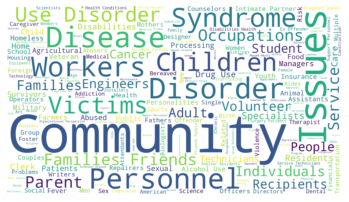

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

targets = []
for node_idx in taxo_nodes:
    node = taxo_nodes[node_idx]
    if 'facet' not in node:
        continue
    if node['facet'] == 'Target':
        if 'name' not in node:
            print(node)
        targets.append(node['name'])
refs_text = ' '.join(list(targets))



cloud = WordCloud(background_color='white', width=1920, height=1080).generate(refs_text)

plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
cloud.to_file('./targets_wordcloud.png')

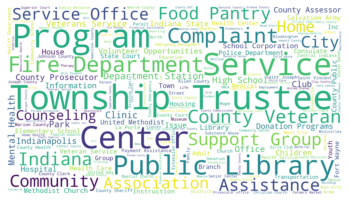

In [0]:
refs_text = ' '.join(list(taxo_refs))



cloud = WordCloud(background_color='white', width=1920, height=1080).generate(refs_text)

plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
cloud.to_file('./user_refs_wordcloud.png')

In [0]:
print("211 data Broadest 2 level of categories:\n")

code_to_name = {1: {}, 2: {}, 4: {}, 5: {}, 6: {}, }
for code in code_to_node_num:
    
    node = taxo_nodes[code_to_node_num[code]]
    if len(code) == 1:
      code_to_name[1][code[:1]] = node['name']
    if len(code) == 2:
      code_to_name[2][code[:2]] = node['name']
    # skipping 3 because of hyphen separator
    
    if len(code) == 4:
      code_to_name[4][code[:4]] = node['name']
    
    if len(code) == 5:
      code_to_name[5][code[:5]] = node['name']
    
    if len(code) == 6:
      code_to_name[6][code[:6]] = node['name']
        # print (node['name'])

211 data Broadest 2 level of categories:



In [0]:
save_to_json(code_to_name, 'data/code_to_name.json')

### Make separate Service only network
To be used for homogeneous attributed network embedding and clustering

In [0]:
services_edgelist = set()
services_network = {}

for node_num in taxo_nodes:
    
    node = taxo_nodes[node_num]
    if node['type'] == 'S':
        for code in node['codes']:
            code_serv_nums = code_to_services[code]
            
            # add relations for services with the same code
            for cn in code_serv_nums:
                services_edgelist.add((str(node_num), str(cn)))
            
            # add relations for 2 hop neighbors of services
            # ie services with related codes
            code_node = taxo_nodes[code_to_node_num[code]]
            if 'related' in code_node:
                for rel in code_node['related']:
                    code_serv_nums = code_to_services[code]
                    for cn in code_serv_nums:
                        services_edgelist.add((str(node_num), str(cn)))
        services_network[node_num] = node

# make sure edgelist has a header at beginning of file
services_edgelist = [('From', 'To')] + list(services_edgelist)

In [0]:
print("Services network has {} nodes".format(len(services_network)))
print("Services network has {} edges".format(len(services_edgelist)))

Services network has 16547 nodes
Services network has 1451204 edges


In [0]:
save_to_json(services_network, '/data/services_nodes.json')
save_to_csv(services_edgelist, '/data/services_edgelist.csv')